/tmp/ipykernel_28497/3803841577.py:53: DeprecationWarning: DEPRECATED: replace `path.to_planar`->`path.to_2D), removal 1/1/2026
  planar, T = sec.to_planar()


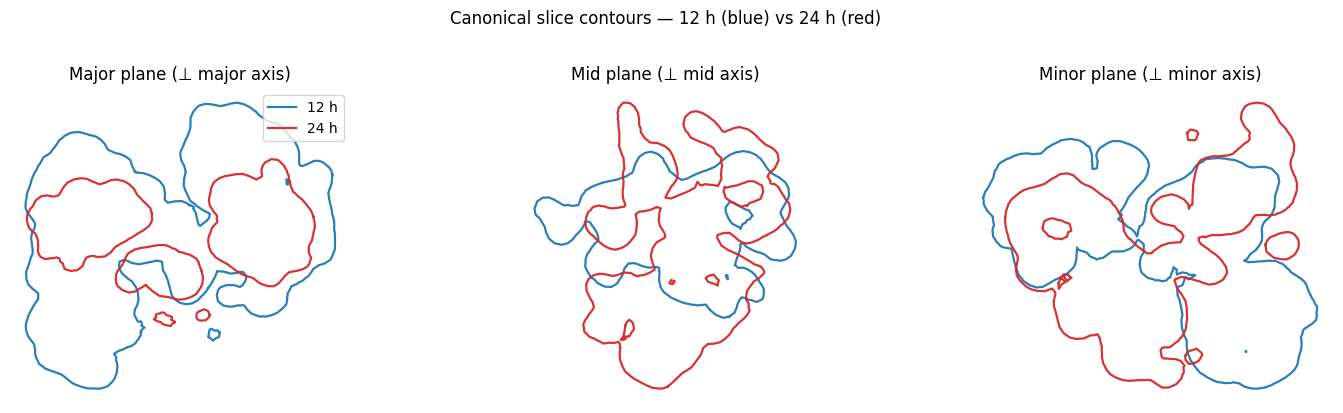

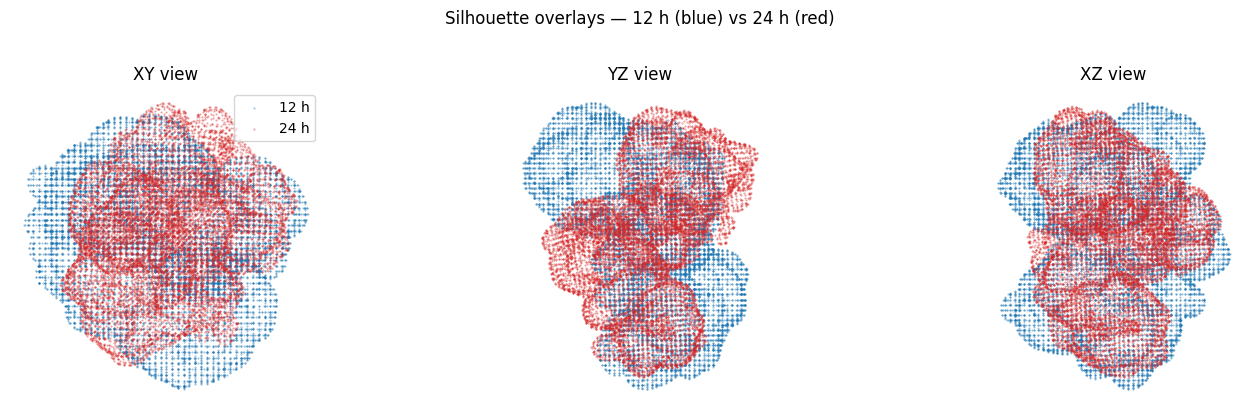

=== Metrics (12 h) ===
volume                  : -248.61060456036276
surface_area            : 383.00782338763446
sphericity              : nan
axis_lengths_(maj,mid,min): (12.056226372511365, 9.050826172037077, 7.150777668556607)
anisotropy_(maj/min)    : 1.686002128904803

=== Metrics (24 h) ===
volume                  : -158.78634725436257
surface_area            : 316.76489396404787
sphericity              : nan
axis_lengths_(maj,mid,min): (10.611690203944509, 7.83634196545648, 7.52251418677487)
anisotropy_(maj/min)    : 1.4106573866754064

=== Δ% (24 h vs 12 h) ===
volume                  : -36.13%
surface_area            : -17.30%
sphericity              : nan%
anisotropy_(maj/min)    : -16.33%


In [1]:
# === A/B Slices + Silhouettes + Metrics (drop-in cell) ===================
import numpy as np, trimesh
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# ---------------------- small helpers ------------------------------------
def center_vertices(m):
    v = m.vertices - m.vertices.mean(axis=0)
    return trimesh.Trimesh(vertices=v, faces=m.faces, process=False)

def kabsch(P, Q):
    """Rigid fit Q->P (same #points). Returns R(3x3), t(3,)."""
    Pc = P.mean(0); Qc = Q.mean(0)
    P0 = P - Pc; Q0 = Q - Qc
    H = Q0.T @ P0
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1
        R = Vt.T @ U.T
    t = Pc - Qc @ R.T
    return R, t

def icp_rigid(A_pts, B_pts, iters=10, sample=5000):
    """ iterative closest point
    Align B->A using nearest-neighbor ICP."""
    A = A_pts if len(A_pts) <= sample else A_pts[np.random.choice(len(A_pts), sample, replace=False)]
    B = B_pts if len(B_pts) <= sample else B_pts[np.random.choice(len(B_pts), sample, replace=False)]
    R = np.eye(3); t = np.zeros(3)
    for _ in range(iters):
        Bx = B @ R.T + t
        tree = cKDTree(A)
        d, idx = tree.query(Bx, k=1)
        P = A[idx]
        R_upd, t_upd = kabsch(P, Bx)
        R = R_upd @ R
        t = (t @ R_upd.T) + t_upd
    return R, t

def pca_axes(verts):
    C = np.cov(verts.T)
    w, V = np.linalg.eigh(C)  # ascending
    order = np.argsort(w)[::-1]
    return V[:, order]  # columns: major, mid, minor

def section_paths_2d(mesh, origin, normal):
    """Slice mesh by plane; return list of 2D polylines in that plane."""
    sec = mesh.section(plane_origin=origin, plane_normal=normal)
    if sec is None: return []
    planar, T = sec.to_planar()
    polys = []
    for ent in planar.entities:
        pts = planar.vertices[ent.points]
        polys.append(pts)
    return polys

def plot_polylist(ax, polys, color, label=None):
    for k, pts in enumerate(polys):
        ax.plot(pts[:,0], pts[:,1], color=color, lw=1.6, alpha=0.95, label=(label if k==0 else None))

def ortho_outline_2d(mesh, axes=(0,1)):
    """Project vertices to 2D plane (axes tuple) and draw outline by alpha hull-like trick."""
    # Quick scatter (outline effect via low alpha + thicker edge)
    uv = mesh.vertices[:, axes]
    return uv

def sphericity(volume, area):
    if volume <= 0 or area <= 0: return np.nan
    return (np.pi**(1/3)) * ((6*volume)**(2/3)) / area

# ---------------------- two meshes path -------------------------
meshA_path = "data/green_monkey/all_structure_files/chr1/spatial_data/overall_shapes/chr1_12hrs_vacv_metaball.obj"
meshB_path = "data/green_monkey/all_structure_files/chr1/spatial_data/overall_shapes/chr1_24hrs_vacv_metaball.obj" 

# ---------------------- load + align -------------------------------------
mA = center_vertices(trimesh.load(meshA_path, process=False))
mB_raw = center_vertices(trimesh.load(meshB_path, process=False))

R, t = icp_rigid(mA.vertices, mB_raw.vertices, iters=12, sample=8000)
mB = trimesh.Trimesh(vertices=mB_raw.vertices @ R.T + t, faces=mB_raw.faces, process=False)

# PCA frame from A
axes = pca_axes(mA.vertices)   # columns are unit vectors
ctr = np.zeros(3)              # after centering, origin is 0

# ---------------------- slice overlays -----------------------------------
planes = [
    ("Major plane (⊥ major axis)",  axes[:,2]),  # normal = minor axis -> section shows major/mid
    ("Mid plane (⊥ mid axis)",      axes[:,0]),  # normal = major axis
    ("Minor plane (⊥ minor axis)",  axes[:,1])   # normal = mid axis
]

fig, axs = plt.subplots(1, 3, figsize=(15,4))
for ax, (title, normal) in zip(axs, planes):
    pA = section_paths_2d(mA, ctr, normal)
    pB = section_paths_2d(mB, ctr, normal)
    plot_polylist(ax, pA, color="#1f77b4", label="12 h")
    plot_polylist(ax, pB, color="#d62728", label="24 h")
    ax.set_aspect('equal', 'box'); ax.set_title(title); ax.axis('off')
axs[0].legend(loc="upper right")
plt.suptitle("Canonical slice contours — 12 h (blue) vs 24 h (red)", y=1.02, fontsize=12)
plt.tight_layout(); plt.show()

# ---------------------- silhouette overlays (3 orthographic views) -------
views = [("XY view", (0,1)), ("YZ view", (1,2)), ("XZ view", (0,2))]
fig, axs = plt.subplots(1,3, figsize=(15,4))
for ax, (title, axes2) in zip(axs, views):
    uvA = ortho_outline_2d(mA, axes=axes2)
    uvB = ortho_outline_2d(mB, axes=axes2)
    ax.scatter(uvA[:,0], uvA[:,1], s=0.2, c="#1f77b4", alpha=0.5, label="12 h")
    ax.scatter(uvB[:,0], uvB[:,1], s=0.2, c="#d62728", alpha=0.5, label="24 h")
    ax.set_aspect('equal', 'box'); ax.set_title(title); ax.axis('off')
axs[0].legend(loc="upper right")
plt.suptitle("Silhouette overlays — 12 h (blue) vs 24 h (red)", y=1.02, fontsize=12)
plt.tight_layout(); plt.show()

# ---------------------- quick metrics ------------------------------------
def basic_metrics(m):
    vol = m.volume if m.is_watertight else np.nan
    area = m.area
    # Axis lengths via PCA std devs (×2 for diameter-ish measure)
    A = pca_axes(m.vertices)
    coords_in_pca = (m.vertices - m.vertices.mean(0)) @ A
    extents = coords_in_pca.ptp(0)  # range along each axis
    maj, mid, minr = extents
    return {
        "volume": float(vol),
        "surface_area": float(area),
        "sphericity": float(sphericity(vol, area)) if np.isfinite(vol) else np.nan,
        "axis_lengths_(maj,mid,min)": (float(maj), float(mid), float(minr)),
        "anisotropy_(maj/min)": float(maj / max(minr, 1e-8))
    }

mA_stats = basic_metrics(mA)
mB_stats = basic_metrics(mB)

print("=== Metrics (12 h) ===")
for k,v in mA_stats.items(): print(f"{k:24s}: {v}")
print("\n=== Metrics (24 h) ===")
for k,v in mB_stats.items(): print(f"{k:24s}: {v}")

def pct_change(a, b):
    return (b - a) / a * 100.0 if a and np.isfinite(a) and a != 0 else np.nan

print("\n=== Δ% (24 h vs 12 h) ===")
for key in ["volume", "surface_area", "sphericity", "anisotropy_(maj/min)"]:
    print(f"{key:24s}: {pct_change(mA_stats[key], mB_stats[key]):.2f}%")


=== Alignment diagnostics (B -> A) ===
Before (centered only):       RMSE = 0.890,  Hausdorff ≈ 3.521
After best PCA pre-align:     RMSE = 0.456,  Hausdorff ≈ 1.597
After robust ICP (final):     RMSE = 0.444,  Hausdorff ≈ 1.474
ICP RMSE per-iter (tail):     [0.3835 0.3833 0.3832 0.383  0.3829]


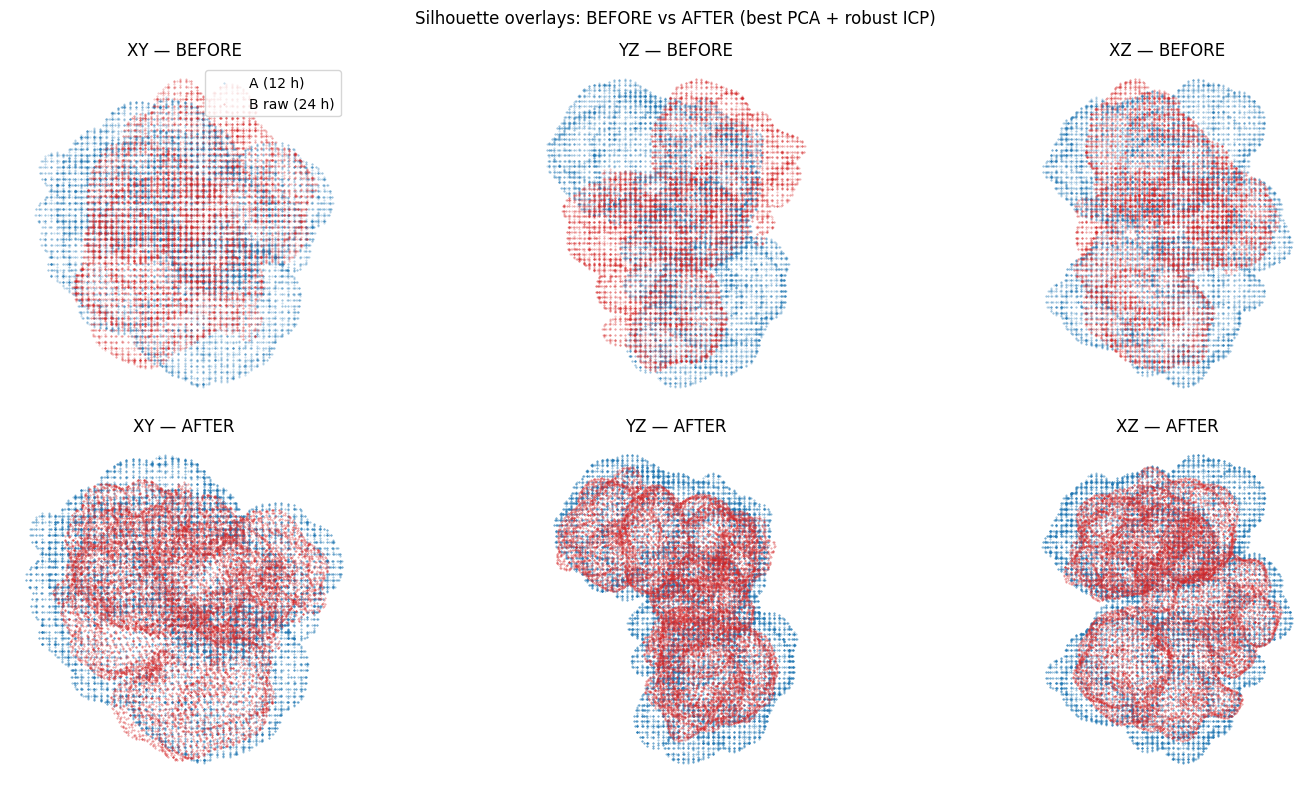

/tmp/ipykernel_22153/3521075895.py:99: DeprecationWarning: DEPRECATED: replace `path.to_planar`->`path.to_2D), removal 1/1/2026
  planar, _ = sec.to_planar()


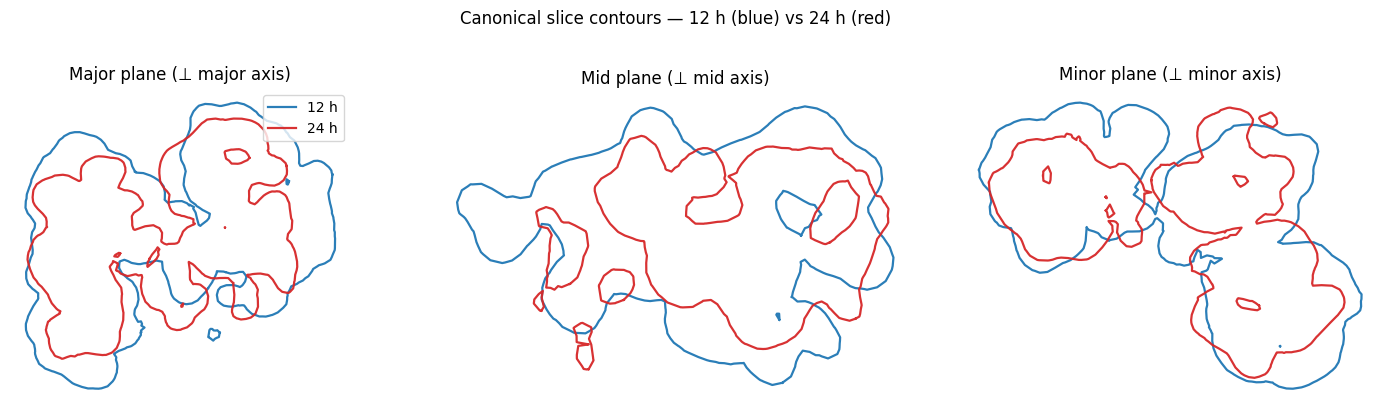

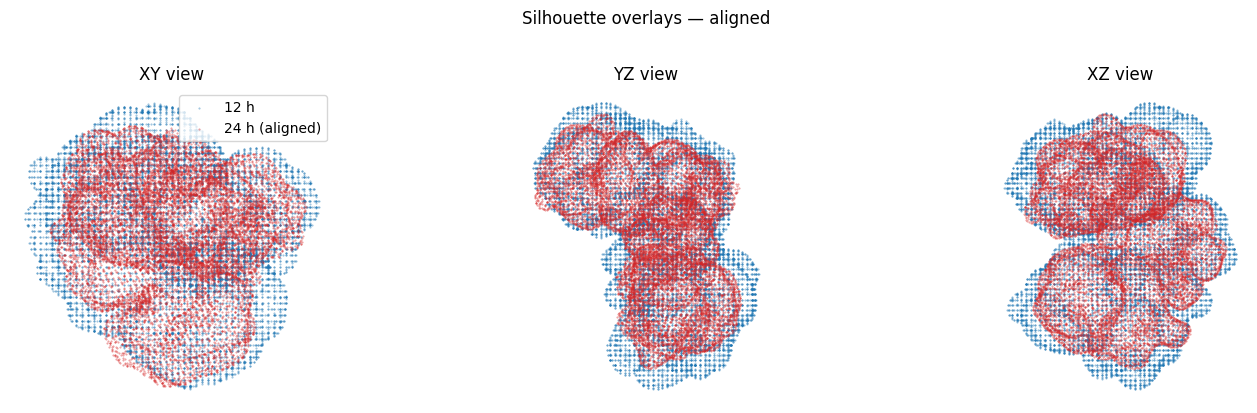


=== Metrics (12 h) ===
volume                  : -248.61060456036276
surface_area            : 383.00782338763446
sphericity              : nan
axis_lengths_(maj,mid,min): (12.056226372511365, 9.050826172037077, 7.150777668556607)
anisotropy_(maj/min)    : 1.686002128904803

=== Metrics (24 h, aligned) ===
volume                  : -158.78634725436146
surface_area            : 316.7648939640464
sphericity              : nan
axis_lengths_(maj,mid,min): (10.611690203944484, 7.836341965456461, 7.522514186774851)
anisotropy_(maj/min)    : 1.4106573866754069

=== Δ% (24 h vs 12 h) ===
volume                  : -36.13%
surface_area            : -17.30%
sphericity              : nan%
anisotropy_(maj/min)    : -16.33%


In [2]:
# === Robust A/B Alignment (best PCA perm/sign + robust ICP) + Slices/Silhouettes/Metrics ===
import numpy as np, itertools, trimesh
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# ---------------------- utils --------------------------------------------
def center_vertices(m):
    v = m.vertices - m.vertices.mean(axis=0)
    return trimesh.Trimesh(vertices=v, faces=m.faces, process=False)

def kabsch(P, Q):
    Pc = P.mean(0); Qc = Q.mean(0)
    P0 = P - Pc; Q0 = Q - Qc
    H = Q0.T @ P0
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1,:] *= -1
        R = Vt.T @ U.T
    t = Pc - Qc @ R.T
    return R, t

def pca_axes(verts):
    C = np.cov(verts.T)
    w, V = np.linalg.eigh(C)
    V = V[:, np.argsort(w)[::-1]]
    if np.linalg.det(V) < 0:  # right-handed
        V[:, -1] *= -1
    return V

def nn_metrics(A_pts, B_pts):
    treeA = cKDTree(A_pts); dBA, _ = treeA.query(B_pts, k=1)
    treeB = cKDTree(B_pts); dAB, _ = treeB.query(A_pts, k=1)
    rmse = float(np.sqrt((np.concatenate([dBA, dAB])**2).mean()))
    haus = float(max(dBA.max(), dAB.max()))
    return rmse, haus

def sample_even(mesh, n=40000, rng=42):
    # Even surface sampling (fallback to vertices if mesh has issues)
    try:
        pts, _ = trimesh.sample.sample_surface_even(mesh, n)
        return pts
    except Exception:
        v = mesh.vertices
        if len(v) > n:
            rs = np.random.default_rng(rng)
            return v[rs.choice(len(v), n, replace=False)]
        return v

# ---------------------- best PCA pre-align --------------------------------
def best_pca_prealign(B_pts, A_pts):
    Va = pca_axes(A_pts)   # world -> A-PCA
    Vb = pca_axes(B_pts)   # world -> B-PCA
    perms = list(itertools.permutations(range(3)))
    signs = list(itertools.product([1, -1], repeat=3))
    best_R = np.eye(3); best_rmse = np.inf

    for p in perms:
        P = np.zeros((3,3)); P[range(3), list(p)] = 1   # permutation matrix
        for s in signs:
            S = np.diag(s)
            # Map B basis to A basis with perm+sign:
            # columns: Va * (P @ S) * Vb.T
            R = Va @ (P @ S) @ Vb.T
            B_try = B_pts @ R.T
            rmse, _ = nn_metrics(A_pts, B_try)
            if rmse < best_rmse:
                best_rmse, best_R = rmse, R
    return best_R, best_rmse

# ---------------------- robust ICP ---------------------------------------
def icp_rigid_robust(A_pts, B_pts, iters=30, sample=50000, trim_q=0.10, seed=7):
    rs = np.random.default_rng(seed)
    A = A_pts if len(A_pts) <= sample else A_pts[rs.choice(len(A_pts), sample, replace=False)]
    B = B_pts if len(B_pts) <= sample else B_pts[rs.choice(len(B_pts), sample, replace=False)]
    R = np.eye(3); t = np.zeros(3)
    rmse_hist = []

    for _ in range(iters):
        Bx = B @ R.T + t
        tree = cKDTree(A)
        d, idx = tree.query(Bx, k=1)
        P = A[idx]
        # Trim top-q% largest distances (robust to outliers/mismatch)
        if 0.0 < trim_q < 0.5:
            thr = np.quantile(d, 1 - trim_q)
            keep = d <= thr
            P, Bx = P[keep], Bx[keep]
        R_upd, t_upd = kabsch(P, Bx)
        R = R_upd @ R
        t = (t @ R_upd.T) + t_upd
        rmse_hist.append(float(np.sqrt((d**2).mean())))
    return R, t, rmse_hist

# ---------------------- plotting helpers ---------------------------------
def section_paths_2d(mesh, origin, normal):
    sec = mesh.section(plane_origin=origin, plane_normal=normal)
    if sec is None: return []
    planar, _ = sec.to_planar()
    polys = []
    for ent in getattr(planar, "entities", []):
        pts = planar.vertices[ent.points]
        polys.append(pts)
    return polys

def plot_polylist(ax, polys, color, label=None):
    for k, pts in enumerate(polys):
        ax.plot(pts[:,0], pts[:,1], color=color, lw=1.6, alpha=0.95, label=(label if k==0 else None))

def ortho_outline_2d(mesh, axes=(0,1), stride=1):
    uv = mesh.vertices[::stride, :][:, axes]
    return uv

def sphericity(volume, area):
    if not (np.isfinite(volume) and np.isfinite(area)) or volume <= 0 or area <= 0:
        return np.nan
    return (np.pi**(1/3)) * ((6*volume)**(2/3)) / area

def basic_metrics(m):
    vol  = m.volume if m.is_watertight else np.nan
    area = m.area
    A = pca_axes(m.vertices)
    coords = (m.vertices - m.vertices.mean(0)) @ A
    extents = coords.ptp(0)  # (maj, mid, min)
    maj, mid, minr = extents
    return {
        "volume": float(vol),
        "surface_area": float(area),
        "sphericity": float(sphericity(vol, area)) if np.isfinite(vol) else np.nan,
        "axis_lengths_(maj,mid,min)": (float(maj), float(mid), float(minr)),
        "anisotropy_(maj/min)": float(maj / max(minr, 1e-8))
    }

# ---------------------- paths --------------------------------------------
meshA_path = "data/green_monkey/all_structure_files/chr1/spatial_data/overall_shapes/chr1_12hrs_vacv_metaball.obj"
meshB_path = "data/green_monkey/all_structure_files/chr1/spatial_data/overall_shapes/chr1_24hrs_vacv_metaball.obj"

# ---------------------- load & center ------------------------------------
mA = center_vertices(trimesh.load(meshA_path, process=False))
mB0 = center_vertices(trimesh.load(meshB_path, process=False))

# Use evenly sampled surface points for alignment robustness
A_pts = sample_even(mA, n=40000)
B_pts = sample_even(mB0, n=40000)

# ---------------------- diagnostics: BEFORE -------------------------------
rmse0, hd0 = nn_metrics(A_pts, B_pts)

# ---------------------- best PCA pre-align --------------------------------
R_pre, rmse_pre = best_pca_prealign(B_pts, A_pts)
B1_pts = B_pts @ R_pre.T
rmse1, hd1 = nn_metrics(A_pts, B1_pts)

# ---------------------- robust ICP ---------------------------------------
R_icp, t_icp, rmse_hist = icp_rigid_robust(A_pts, B1_pts, iters=30, sample=50000, trim_q=0.10, seed=11)
R_all = R_icp @ R_pre
t_all = t_icp

# Apply to the full mesh
mB = trimesh.Trimesh(vertices=mB0.vertices @ R_all.T + t_all, faces=mB0.faces, process=False)

# Final diagnostics on full vertices (bidirectional)
rmse2, hd2 = nn_metrics(mA.vertices, mB.vertices)

print("=== Alignment diagnostics (B -> A) ===")
print(f"Before (centered only):       RMSE = {rmse0:.3f},  Hausdorff ≈ {hd0:.3f}")
print(f"After best PCA pre-align:     RMSE = {rmse1:.3f},  Hausdorff ≈ {hd1:.3f}")
print(f"After robust ICP (final):     RMSE = {rmse2:.3f},  Hausdorff ≈ {hd2:.3f}")
print(f"ICP RMSE per-iter (tail):     {np.array(rmse_hist[-5:]).round(4)}")

# ---------------------- BEFORE vs AFTER silhouettes -----------------------
views = [("XY", (0,1)), ("YZ", (1,2)), ("XZ", (0,2))]
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for j,(title, axes2) in enumerate(views):
    # Row 0: before
    uvA0 = mA.vertices[:, axes2]; uvB0 = mB0.vertices[:, axes2]
    ax = axs[0, j]
    ax.scatter(uvA0[:,0], uvA0[:,1], s=0.15, c="#1f77b4", alpha=0.35, label="A (12 h)")
    ax.scatter(uvB0[:,0], uvB0[:,1], s=0.15, c="#d62728", alpha=0.35, label="B raw (24 h)")
    ax.set_aspect('equal', 'box'); ax.set_title(f"{title} — BEFORE"); ax.axis('off')
    if j==0: ax.legend(loc="upper right")
    # Row 1: after
    uvA = mA.vertices[:, axes2]; uvB = mB.vertices[:, axes2]
    ax = axs[1, j]
    ax.scatter(uvA[:,0], uvA[:,1], s=0.15, c="#1f77b4", alpha=0.55, label="A (12 h)")
    ax.scatter(uvB[:,0], uvB[:,1], s=0.15, c="#d62728", alpha=0.55, label="B aligned (24 h)")
    ax.set_aspect('equal', 'box'); ax.set_title(f"{title} — AFTER"); ax.axis('off')
plt.suptitle("Silhouette overlays: BEFORE vs AFTER (best PCA + robust ICP)", y=0.98)
plt.tight_layout(); plt.show()

# ---------------------- canonical slices (A's PCA frame) ------------------
axesA = pca_axes(mA.vertices); ctr = np.zeros(3)
planes = [
    ("Major plane (⊥ major axis)",  axesA[:,2]),
    ("Mid plane (⊥ mid axis)",      axesA[:,0]),
    ("Minor plane (⊥ minor axis)",  axesA[:,1])
]
fig, axs = plt.subplots(1, 3, figsize=(15,4))
for ax, (title, normal) in zip(axs, planes):
    pA = section_paths_2d(mA, ctr, normal)
    pB = section_paths_2d(mB, ctr, normal)
    plot_polylist(ax, pA, color="#1f77b4", label="12 h")
    plot_polylist(ax, pB, color="#d62728", label="24 h")
    ax.set_aspect('equal', 'box'); ax.set_title(title); ax.axis('off')
axs[0].legend(loc="upper right")
plt.suptitle("Canonical slice contours — 12 h (blue) vs 24 h (red)", y=1.02, fontsize=12)
plt.tight_layout(); plt.show()

# ---------------------- final silhouettes --------------------------------
fig, axs = plt.subplots(1,3, figsize=(15,4))
for ax, (title, axes2) in zip(axs, views):
    uvA = mA.vertices[:, axes2]; uvB = mB.vertices[:, axes2]
    ax.scatter(uvA[:,0], uvA[:,1], s=0.2, c="#1f77b4", alpha=0.5, label="12 h")
    ax.scatter(uvB[:,0], uvB[:,1], s=0.2, c="#d62728", alpha=0.5, label="24 h (aligned)")
    ax.set_aspect('equal', 'box'); ax.set_title(f"{title} view"); ax.axis('off')
axs[0].legend(loc="upper right")
plt.suptitle("Silhouette overlays — aligned", y=1.02, fontsize=12)
plt.tight_layout(); plt.show()

# ---------------------- metrics ------------------------------------------
def sphericity(volume, area):
    if not (np.isfinite(volume) and np.isfinite(area)) or volume <= 0 or area <= 0:
        return np.nan
    return (np.pi**(1/3)) * ((6*volume)**(2/3)) / area

def basic_metrics(m):
    vol  = m.volume if m.is_watertight else np.nan
    area = m.area
    A = pca_axes(m.vertices)
    coords = (m.vertices - m.vertices.mean(0)) @ A
    extents = coords.ptp(0)
    maj, mid, minr = extents
    return {
        "volume": float(vol),
        "surface_area": float(area),
        "sphericity": float(sphericity(vol, area)) if np.isfinite(vol) else np.nan,
        "axis_lengths_(maj,mid,min)": (float(maj), float(mid), float(minr)),
        "anisotropy_(maj/min)": float(maj / max(minr, 1e-8))
    }

mA_stats = basic_metrics(mA)
mB_stats = basic_metrics(mB)

print("\n=== Metrics (12 h) ===")
for k,v in mA_stats.items(): print(f"{k:24s}: {v}")
print("\n=== Metrics (24 h, aligned) ===")
for k,v in mB_stats.items(): print(f"{k:24s}: {v}")

def pct_change(a, b):
    return (b - a) / a * 100.0 if (a is not None) and np.isfinite(a) and a != 0 else np.nan

print("\n=== Δ% (24 h vs 12 h) ===")
for key in ["volume", "surface_area", "sphericity", "anisotropy_(maj/min)"]:
    print(f"{key:24s}: {pct_change(mA_stats[key], mB_stats[key]):.2f}%")
